In [ ]:
数据抓取自来自英国的二手汽车共10W条数据，按照品牌分成若干个csv文件。
该数据集包括价格，变速器，里程数，燃油类型，路税，每加仑英里数，发动机规格等特征

In [1]:
#导入库
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

import xgboost as xgb
import lightgbm as lgbm
import shap

from scipy.stats import normaltest
from statsmodels.graphics.gofplots import qqplot

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error as MSE
from sklearn.metrics import r2_score
from sklearn.model_selection import RandomizedSearchCV

sns.set_style("whitegrid")
sns.despine()
sns.set_color_codes('bright')

plt.style.use("seaborn-whitegrid")
plt.rc("figure", autolayout=True)
plt.rc("axes", labelweight="bold", labelsize="large", titleweight="bold", titlesize=14, titlepad=10)

<Figure size 432x288 with 0 Axes>

# 探索性数据分析

In [2]:
#读取数据（以奥迪为例）
df=pd.read_csv('/Users/wenliang/Documents/个人项目及其数据集/二手车价格预测/audi.csv',skipinitialspace=True)#skiointialspace 忽略分隔符后的空白

In [3]:
df.head()

,model,year,price,transmission,mileage,fuelType,tax,mpg,engineSize
0,A1,2017,12500,Manual,15735,Petrol,150,55.4,1.4
1,A6,2016,16500,Automatic,36203,Diesel,20,64.2,2.0
2,A1,2016,11000,Manual,29946,Petrol,30,55.4,1.4
3,A4,2017,16800,Automatic,25952,Diesel,145,67.3,2.0
4,A3,2019,17300,Manual,1998,Petrol,145,49.6,1.0


In [4]:
#重新排列，后面先对分类变量分组，再对数值变量分组
df=df[['model','year','transmission','fuelType','mileage','tax','mpg','engineSize','price']]

In [5]:
df.head(10)

,model,year,transmission,fuelType,mileage,tax,mpg,engineSize,price
0,A1,2017,Manual,Petrol,15735,150,55.4,1.4,12500
1,A6,2016,Automatic,Diesel,36203,20,64.2,2.0,16500
2,A1,2016,Manual,Petrol,29946,30,55.4,1.4,11000
3,A4,2017,Automatic,Diesel,25952,145,67.3,2.0,16800
4,A3,2019,Manual,Petrol,1998,145,49.6,1.0,17300
5,A1,2016,Automatic,Petrol,32260,30,58.9,1.4,13900
6,A6,2016,Automatic,Diesel,76788,30,61.4,2.0,13250
7,A4,2016,Manual,Diesel,75185,20,70.6,2.0,11750
8,A3,2015,Manual,Petrol,46112,20,60.1,1.4,10200
9,A1,2016,Manual,Petrol,22451,30,55.4,1.4,12000


In [6]:
df.info()#没缺失值

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10668 entries, 0 to 10667
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   model         10668 non-null  object 
 1   year          10668 non-null  int64  
 2   transmission  10668 non-null  object 
 3   fuelType      10668 non-null  object 
 4   mileage       10668 non-null  int64  
 5   tax           10668 non-null  int64  
 6   mpg           10668 non-null  float64
 7   engineSize    10668 non-null  float64
 8   price         10668 non-null  int64  
dtypes: float64(2), int64(4), object(3)
memory usage: 750.2+ KB


In [7]:
df['year'] = df['year'].astype(object) #把year 的变量类型变成object了

In [8]:
df_clean = df.copy()

In [9]:
#首先需要知道的是删除mileage里程这个直接反映汽车损耗程度的特征之后，其他的特征还能不能独立识别出一辆车
df_models=df.drop(['price','mileage','tax'], axis=1).drop_duplicates().sort_values(by=['model','year','fuelType'])
df_models.head()
#显然mpg和engineSize不是像model,year,transmission,fuelType那样的唯一标识

,model,year,transmission,fuelType,mpg,engineSize
10632,A1,2010,Automatic,Petrol,53.3,1.4
9625,A1,2011,Manual,Diesel,70.6,1.6
9791,A1,2011,Manual,Petrol,53.3,1.4
7950,A1,2012,Manual,Diesel,74.3,1.6
8101,A1,2012,Manual,Diesel,68.9,2.0


## 先分析数值型特征

In [10]:
#为了方便画图，自定义一个函数用来画所有的数值型特征的图，有直方图和箱线图两种
def num_plots(df):
    fig, ax = plt.subplots(2,5, figsize=(15,8))
    ax[0,0].hist(df['mileage'],density = True, bins = 20)
    ax[0,0].set_title('mileage hist')
    ax[0,1].hist(df['tax'],density = True, bins = 20)
    ax[0,1].set_title('tax hist')
    ax[0,2].hist(df['mpg'],density = True, bins = 20)
    ax[0,2].set_title('mpg hist')
    ax[0,3].hist(df['engineSize'],density = True, bins = 20)
    ax[0,3].set_title('engineSize hist')
    ax[0,4].hist(df['price'],density = True, bins = 20)
    ax[0,4].set_title('price hist')

    ax[1,0].boxplot(df['mileage'])
    ax[1,0].set_title('mileage boxplot')
    ax[1,1].boxplot(df['tax'])
    ax[1,1].set_title('tax boxplot')
    ax[1,2].boxplot(df['mpg'])
    ax[1,2].set_title('mpg boxplot')
    ax[1,3].boxplot(df['engineSize'])
    ax[1,3].set_title('engineSize boxplot')
    ax[1,4].boxplot(df['price'])
    ax[1,4].set_title('price boxplot')
    plt.show()

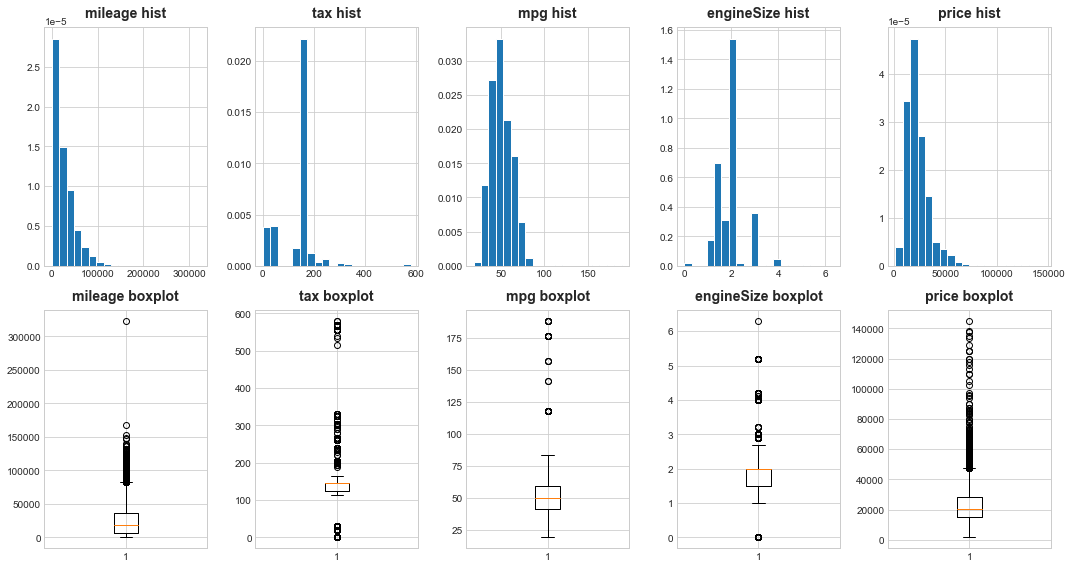

In [11]:
num_plots(df)#显然有异常值，导致图形拖了很长的尾巴

In [12]:
df.describe()

,mileage,tax,mpg,engineSize,price
count,10668.000000,10668.000000,10668.000000,10668.000000,10668.000000
mean,24827.244001,126.011436,50.770022,1.930709,22896.685039
std,23505.257205,67.170294,12.949782,0.602957,11714.841888
min,1.000000,0.000000,18.900000,0.000000,1490.000000
25%,5968.750000,125.000000,40.900000,1.500000,15130.750000
50%,19000.000000,145.000000,49.600000,2.000000,20200.000000
75%,36464.500000,145.000000,58.900000,2.000000,27990.000000
max,323000.000000,580.000000,188.300000,6.300000,145000.000000


通过直方图、箱线图和这张统计表可以看出：
1.mileage均值是25k，过高的值甚至到了32k，在图上明显偏离太多，删除该值
2.tax均值约为126，与前面的里程数类似，存在一些过高的值
3.mpg均值在50左右，和图里看到的相近，整体也接近正态分布
4.engineSize有的竟然是0，这不符合常理，可能是缺失值
5.price拖了很长的尾巴，很明显有极端值影响，有的价格超过了10k

## 删除异常值

In [13]:
#首先定义一个函数绘制分布图和箱线图以便更好的识别异常值
def plots(df,col):
    fig, ax = plt.subplots(1, 2, figsize=(10,4))
    ax[0].hist(df[col])
    ax[0].set_title(col + ' hist')
    ax[1].boxplot(df[col])
    ax[1].set_title(col + ' boxplot')
    plt.show()

In [14]:
df_clean = df #再创建一个dataframe，用来储存清洗后的数据

Text(0.5, 1.0, 'Correlation Matrix')

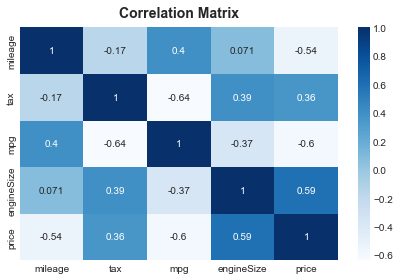

In [15]:
#在分析开始之前，创建一个相关矩阵看看相关性
sns.heatmap(df.corr(), cmap='Blues', annot=True)
plt.title('Correlation Matrix')

从热力图中，我们可以得到以下有关价格的信息：

mpg 和价格之间存在相当适度的负相关 (-0.6)。 这意味着 mpg 高的汽车往往更便宜。

里程数和价格之间存在相当适度的负相关（-0.54）。 这意味着里程数更高的汽车往往更便宜。

税收和价格之间也存在小的正相关 (+0.36)。 税收较高的汽车往往成本更高。

最后，发动机尺寸和价格之间也存在适度的正相关 (0.59)。 发动机尺寸较大的汽车往往成本更高。

其他与价格无关的有趣信息是：

mpg 和里程之间存在适度的正相关 (0.4)：具有高 mpg 的汽车往往具有更高的里程
税收和 mpg 之间存在相当适度的负相关 (-0.64)。 mpg 高的汽车往往税收较低。

## mileage里程数分析

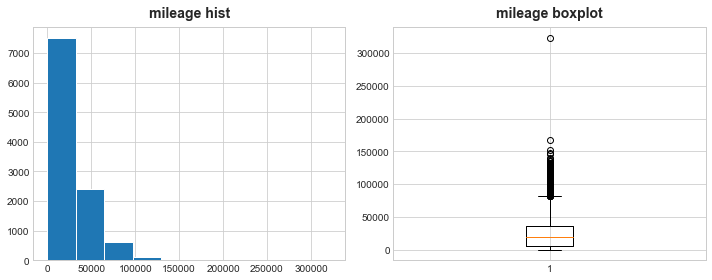

In [16]:
plots(df_clean,'mileage')

In [17]:
df_clean = df_clean[df_clean['mileage'] < 200000]#把200k以上的删除

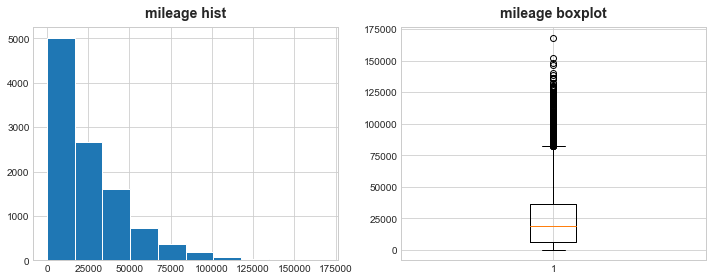

In [18]:
plots(df_clean,'mileage')

In [19]:
df_clean = df_clean[df_clean['mileage'] < 150000]# 依然有150k以上的需要删除

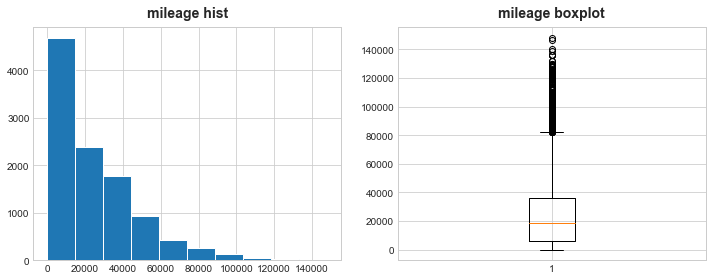

In [20]:
plots(df_clean,'mileage')

In [21]:
print('We removed {} outliers!'.format(len(df) - len(df_clean)))

We removed 3 outliers!


In [22]:
#我们移除了哪些异常值
df[df['mileage'] >= 150000]

,model,year,transmission,fuelType,mileage,tax,mpg,engineSize,price
7404,A3,2009,Manual,Diesel,152034,150,55.4,1.9,2490
9690,Q5,2011,Manual,Diesel,168017,200,42.1,2.0,6195
9822,A6,2008,Manual,Diesel,323000,200,44.1,2.0,2490


这些汽车具有非常高的里程值，通常也具有非常高的税和非常低的价格。 我们也可以从相关矩阵中理解这种现象。

## 每加仑英里数(mpg)分析

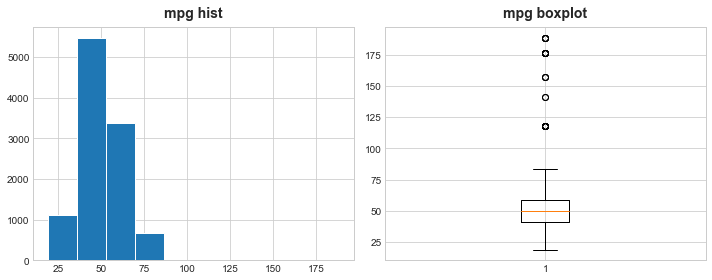

In [23]:
plots(df_clean, 'mpg')

In [24]:
#可以看出来，有部分车的mpg高于100
df_clean[df_clean['mpg']>100]

,model,year,transmission,fuelType,mileage,tax,mpg,engineSize,price
864,A3,2020,Semi-Auto,Hybrid,2165,135,141.3,1.4,31990
1104,Q5,2019,Automatic,Hybrid,6565,135,117.7,2.0,44990
1648,Q5,2020,Semi-Auto,Hybrid,3500,135,117.7,2.0,46450
2550,Q7,2017,Semi-Auto,Hybrid,66477,140,156.9,3.0,32998
3106,A3,2015,Semi-Auto,Hybrid,28294,0,188.3,1.4,14981
3489,Q5,2019,Semi-Auto,Hybrid,2010,135,117.7,2.0,44991
3689,Q5,2020,Semi-Auto,Hybrid,4000,135,117.7,2.0,46000
4095,Q5,2019,Automatic,Hybrid,10000,135,117.7,2.0,45490
4261,A3,2015,Automatic,Hybrid,14000,0,188.3,1.4,17990
4314,Q5,2019,Semi-Auto,Hybrid,8700,135,117.7,2.0,44495


看起来这些车中的大多数是 A3、Q5 或 Q7。 特别是它们都具有自动或半自动变速器，并且大多数具有混合燃料类型。
接下来分析一下所有混合动力的车

In [25]:
df_hyb = df[df['fuelType'] == 'Hybrid']

In [26]:
print('There are {} Hybrid cars in the dataset, which are {} % of the total cars'.format(len(df_hyb),len(df_hyb)/len(df)))


There are 28 Hybrid cars in the dataset, which are 0.0026246719160104987 % of the total cars


事实上，数据集中的混合动力汽车很少。 我们将看看在异常值清理后是否将所有这些都删除。
我们继续从 mpg 列中删除异常值。

In [27]:
df_clean = df_clean[df_clean['mpg'] < 100]

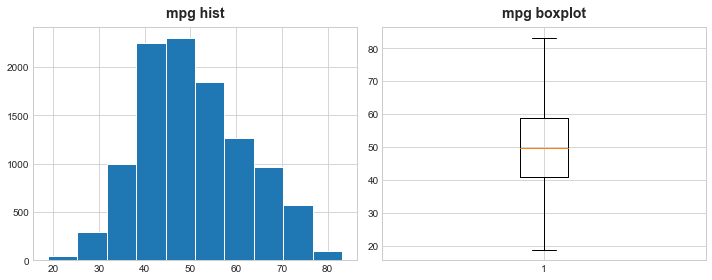

In [28]:
plots(df_clean,'mpg')

目前看来，mpg的分布正常起来了，试着看看它有多正常

marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.


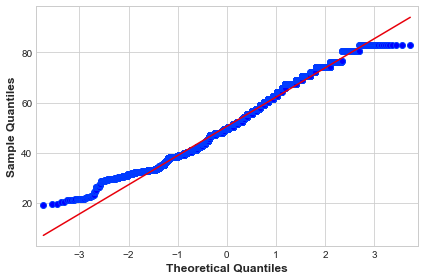

In [29]:
qqplot(df_clean.mpg, line='s')
plt.show()

In [30]:
stat, p = normaltest(df_clean.mpg)
print('Statistics=%.3f, p=%.3f' % (stat, p))
# interpret
alpha = 0.05
if p > alpha:
	print('Sample looks Gaussian (fail to reject H0)')
else:
	print('Sample does not look Gaussian (reject H0)')

Statistics=299.263, p=0.000
Sample does not look Gaussian (reject H0)


分布似乎不是 95% 置信度的正态分布。
特别是从QQplot我们可以看出，问题主要出在分布的尾部。 分布仍然有点右偏。

In [31]:
print('We removed {} outliers!'.format(len(df) - len(df_clean)))

We removed 36 outliers!


## 税(tax)的分析

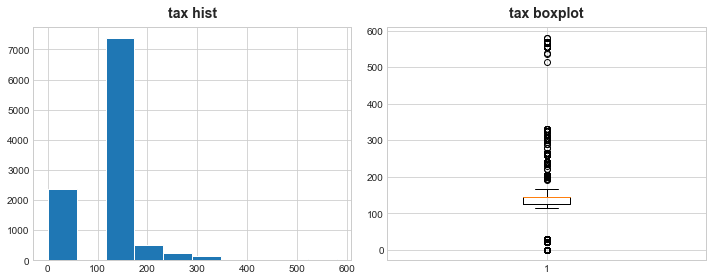

In [32]:
plots(df_clean, 'tax')#有两个异常的群，分别是高于500的和低于100的

In [33]:
df_tax_high = df_clean[df_clean['tax'] > 500]#清除了高于500的那一群

In [34]:
len(df_tax_high)

40

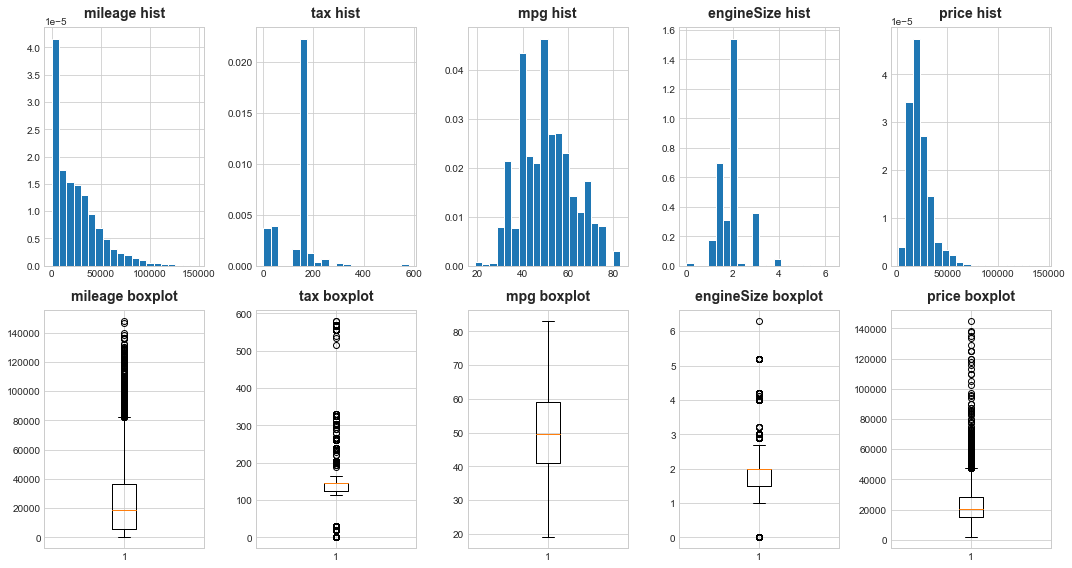

In [35]:
num_plots(df_clean)

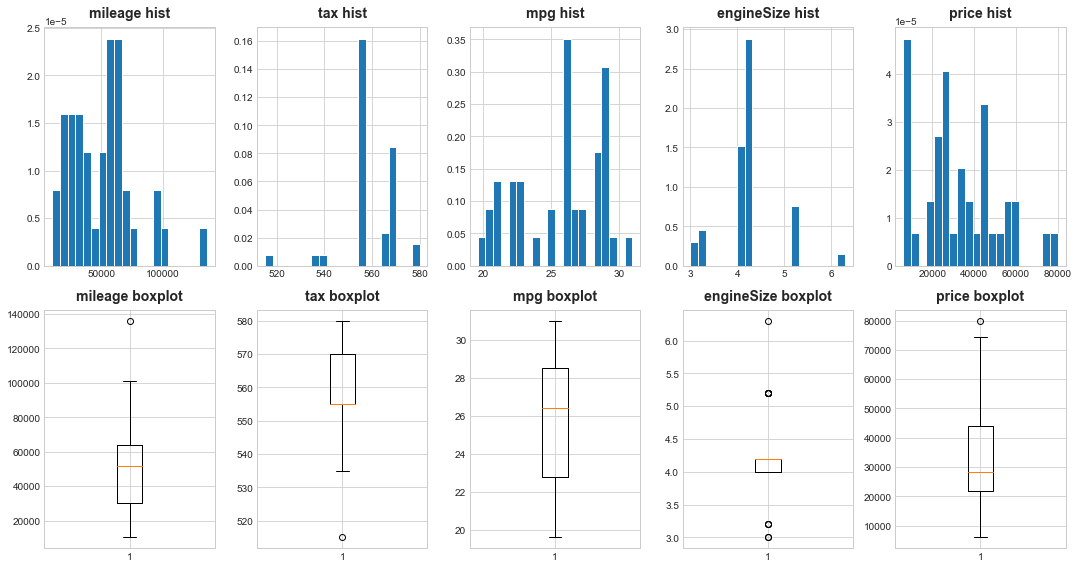

In [36]:
num_plots(df_tax_high)

In [37]:
df_clean = df_clean[df_clean['tax'] < 500]

In [38]:
df_tax_low =  df_clean[df_clean['tax'] < 100]#再清除低于100的那一群

In [39]:
len(df_tax_low)

2353

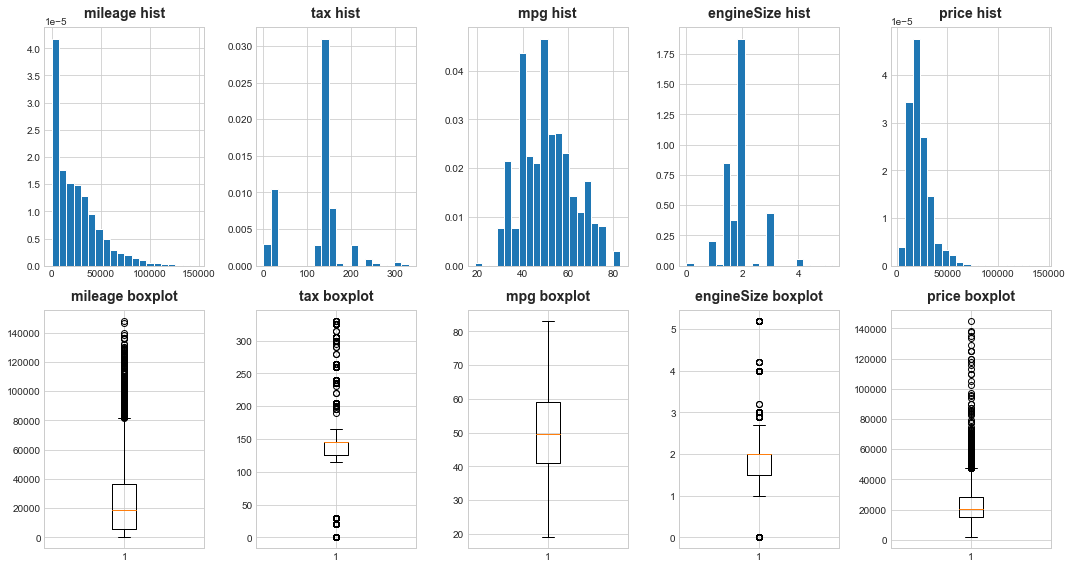

In [40]:
num_plots(df_clean)

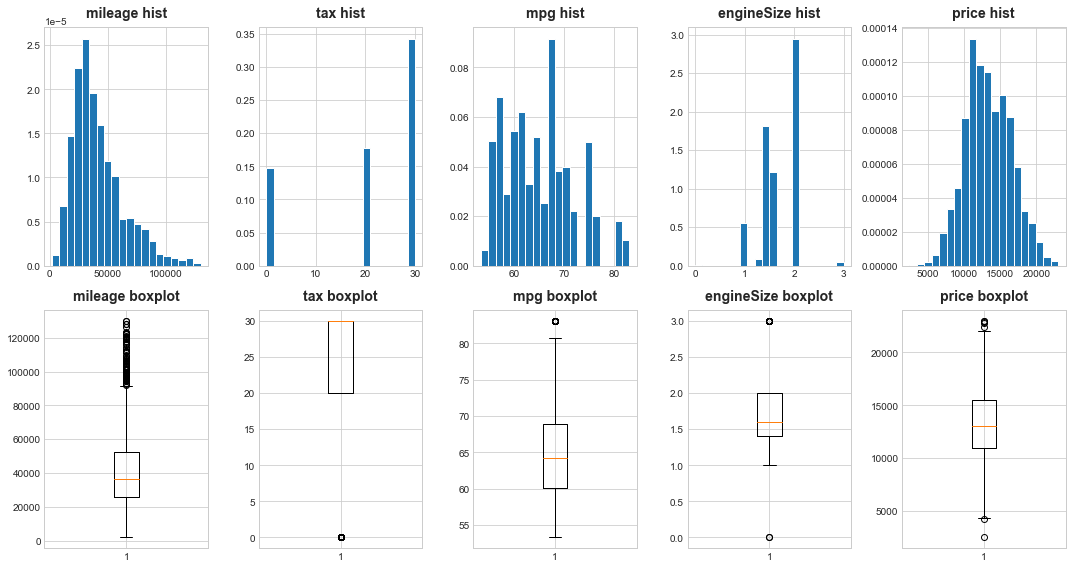

In [41]:
num_plots(df_tax_low)

看起来这些低税值的汽车价格很也很低（有点符合正态分布，平均在 12000 美元左右）

## 发动机规格(engineSize)分析

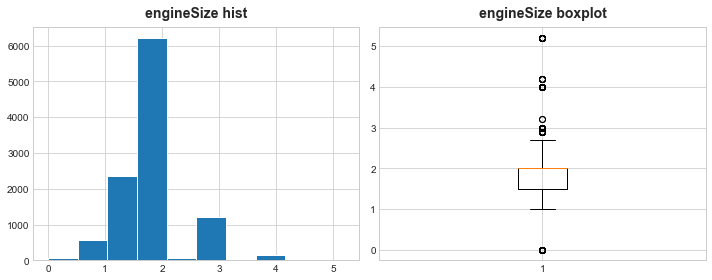

In [42]:
plots(df_clean, 'engineSize')#有一部分是0，有一部分超过了5

In [43]:
df_size_small = df_clean[df_clean['engineSize'] == 0] #先删除是0的那一部分

In [44]:
df_size_small

,model,year,transmission,fuelType,mileage,tax,mpg,engineSize,price
7506,Q3,2019,Automatic,Diesel,1500,145,47.1,0.0,32788
7516,Q3,2020,Manual,Petrol,1500,145,40.9,0.0,29944
7517,Q3,2020,Automatic,Diesel,1500,145,47.1,0.0,33333
7518,Q3,2020,Automatic,Petrol,1500,145,32.5,0.0,29944
7519,Q3,2020,Automatic,Petrol,1500,145,30.7,0.0,37990
7542,Q3,2019,Manual,Petrol,2001,145,40.4,0.0,31888
7545,Q2,2020,Automatic,Petrol,1500,145,42.2,0.0,24988
7546,A3,2017,Manual,Petrol,7110,30,60.1,0.0,17390
7591,Q5,2019,Automatic,Diesel,45,145,39.2,0.0,33390
7598,A3,2019,Manual,Petrol,1500,145,47.1,0.0,22000


In [45]:
len(df_size_small)

54

In [46]:
df_size_small['model'].value_counts()#居然Q3这个型号这么多都是0

Q3     27
A3      7
Q2      6
S4      3
A5      3
Q5      2
SQ5     2
TT      2
A4      1
A1      1
Name: model, dtype: int64

In [47]:
df_q3 = df_clean[df_clean['model']=='Q3']#把Q3型号都删掉吧

In [48]:
len(df_q3)

1417

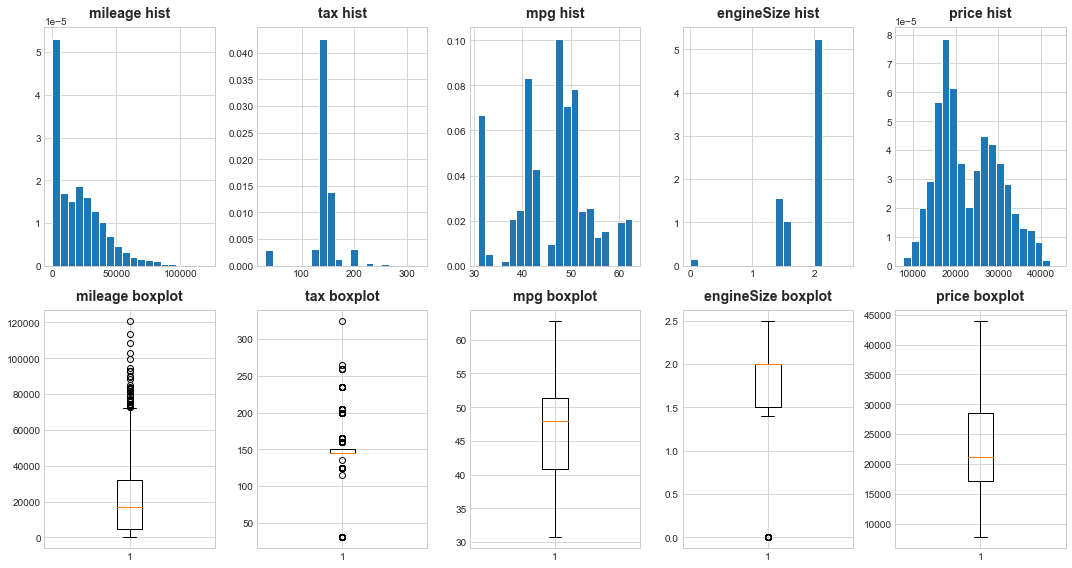

In [49]:
num_plots(df_q3)

In [50]:
df_clean= df_clean[df_clean['engineSize'] > 0]
df_size_big = df_clean[df_clean['engineSize'] > 5]
df_size_big

,model,year,transmission,fuelType,mileage,tax,mpg,engineSize,price
1646,R8,2019,Semi-Auto,Petrol,4000,145,21.4,5.2,129000
2255,R8,2020,Semi-Auto,Petrol,70,145,21.1,5.2,137995
3359,R8,2019,Automatic,Petrol,100,145,24.1,5.2,125000
3367,R8,2019,Automatic,Petrol,1000,145,32.8,5.2,135000
3939,R8,2019,Automatic,Petrol,8175,145,21.6,5.2,112990
4179,R8,2019,Semi-Auto,Petrol,10,150,21.4,5.2,137500
4391,R8,2018,Semi-Auto,Petrol,3800,145,23.0,5.2,93950
4742,R8,2019,Automatic,Petrol,11936,145,21.4,5.2,117990
4783,R8,2020,Semi-Auto,Petrol,2000,145,21.1,5.2,145000
4925,R8,2019,Semi-Auto,Petrol,500,145,21.4,5.2,125000


看起来拥有大发动机的都是A8这个型号的呀

In [51]:
len(df_size_big)

18

In [52]:
df_clean[df_clean['model']=='R8']

,model,year,transmission,fuelType,mileage,tax,mpg,engineSize,price
1646,R8,2019,Semi-Auto,Petrol,4000,145,21.4,5.2,129000
2255,R8,2020,Semi-Auto,Petrol,70,145,21.1,5.2,137995
3359,R8,2019,Automatic,Petrol,100,145,24.1,5.2,125000
3367,R8,2019,Automatic,Petrol,1000,145,32.8,5.2,135000
3939,R8,2019,Automatic,Petrol,8175,145,21.6,5.2,112990
4179,R8,2019,Semi-Auto,Petrol,10,150,21.4,5.2,137500
4391,R8,2018,Semi-Auto,Petrol,3800,145,23.0,5.2,93950
4742,R8,2019,Automatic,Petrol,11936,145,21.4,5.2,117990
4783,R8,2020,Semi-Auto,Petrol,2000,145,21.1,5.2,145000
4925,R8,2019,Semi-Auto,Petrol,500,145,21.4,5.2,125000


这么一看，所有的A8都有大尺寸的发动机，保留这个数据

In [53]:
print('So far we have removed {} outliers !'.format(len(df)-len(df_clean)))

So far we have removed 130 outliers !


## 价格(price)分析

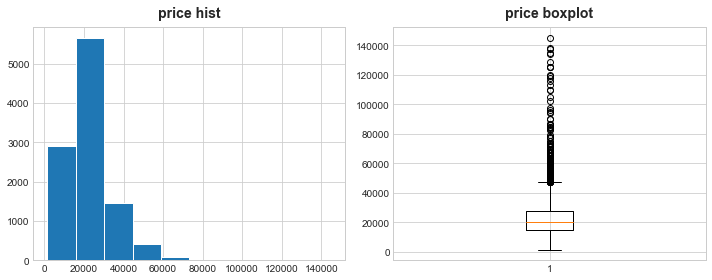

In [54]:
plots(df_clean,'price')

看起来这个分布拖着很撑的尾巴，试试用对数将其归一化？

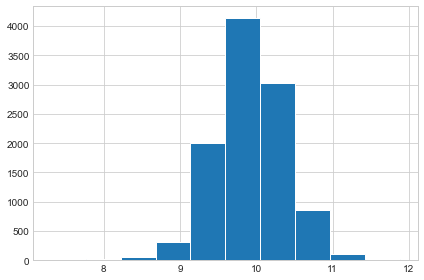

In [55]:
plt.hist(np.log(df_clean['price']))
plt.show()

In [56]:
price_log = np.log(df_clean['price'])

marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.


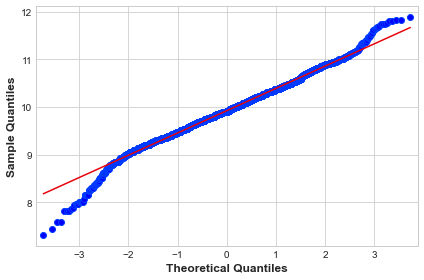

In [57]:
qqplot(price_log, line='s')
plt.show()

In [58]:
stat, p = normaltest(price_log)
print('Statistics=%.3f, p=%.3f' % (stat, p))
# interpret
alpha = 0.05
if p > alpha:
	print('Sample looks Gaussian (fail to reject H0)')
else:
	print('Sample does not look Gaussian (reject H0)')


Statistics=224.328, p=0.000
Sample does not look Gaussian (reject H0)


分布虽然不是正态分布，但是已经很接近了
我们将看看是否可以通过对价格变量进行对数转换来提高ML的预测性能。

## 多变量异常点检测

Text(0.5, 1.0, 'Correlation Matrix')

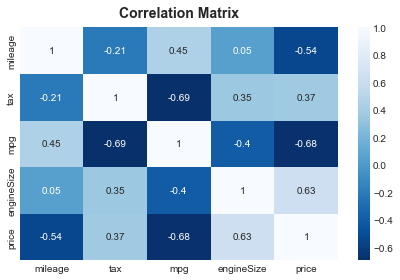

In [59]:
sns.heatmap(df_clean.corr(), cmap='Blues_r', annot=True)
plt.title('Correlation Matrix')

从热力图中可以看出，我们应该对高关联度的特征进行异常值检测

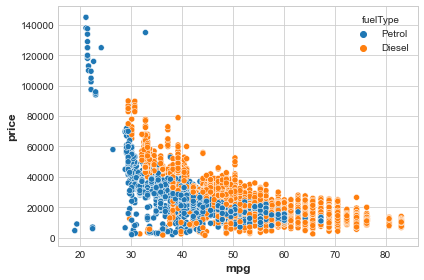

In [60]:
sns.scatterplot(y='price', x='mpg', data=df_clean, hue='fuelType')
plt.show()

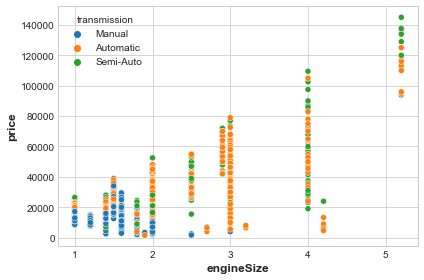

In [61]:
sns.scatterplot(y='price', x='engineSize', data=df_clean, hue='transmission')
plt.show()

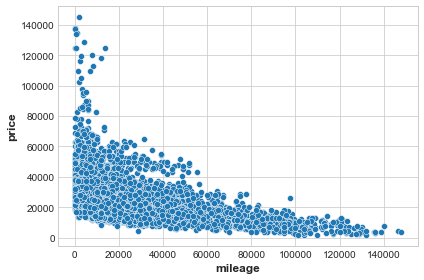

In [62]:
sns.scatterplot(y='price', x='mileage', data=df_clean)
plt.show()

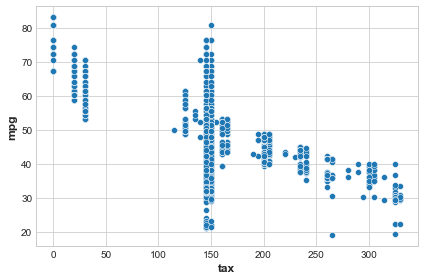

In [63]:
sns.scatterplot(y='mpg', x='tax', data=df_clean)
plt.show()


暂时没有看到删除了对后面模型有提升的异常值，所以数据都保留

In [64]:
print('In total we removed {} outliers!'.format(len(df)-len(df_clean)))

In total we removed 130 outliers!


In [65]:
print('Percentage of removed outliers with respect to dataframe size: {}%'.format(np.round((len(df)-len(df_clean))/len(df),3)))


Percentage of removed outliers with respect to dataframe size: 0.012%


# 特征之间的关系分析

## price与fuelType的关系

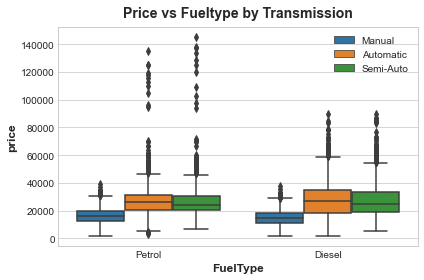

In [66]:
sns.boxplot(x='fuelType', y='price', data=df_clean, hue='transmission');
plt.xlabel('FuelType');
plt.legend(loc='upper right')
plt.title('Price vs Fueltype by Transmission');

自动和半自动变速器的汽车比较昂贵，而手动变速器的汽车则比较便宜。

## transmission和price的关系

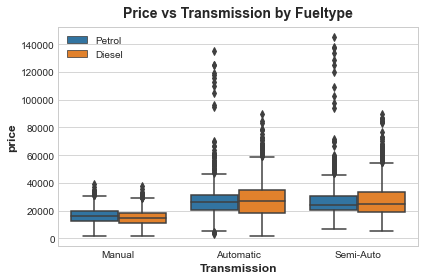

In [67]:
sns.boxplot(x='transmission', y='price', data=df_clean, hue='fuelType');
plt.xlabel('Transmission');
plt.title('Price vs Transmission by Fueltype');
plt.legend(loc='upper left')

带自动或半自动变速器的汽车平均比带手动变速器的汽车贵。
带有手动变速器的汽车的价格比较接近，带有自动或半自动变速器的汽车的价格范围更广。

# 为建模做准备

In [68]:
df_clean.head()

,model,year,transmission,fuelType,mileage,tax,mpg,engineSize,price
0,A1,2017,Manual,Petrol,15735,150,55.4,1.4,12500
1,A6,2016,Automatic,Diesel,36203,20,64.2,2.0,16500
2,A1,2016,Manual,Petrol,29946,30,55.4,1.4,11000
3,A4,2017,Automatic,Diesel,25952,145,67.3,2.0,16800
4,A3,2019,Manual,Petrol,1998,145,49.6,1.0,17300


In [69]:
df_clean.describe()

,mileage,tax,mpg,engineSize,price
count,10538.000000,10538.000000,10538.000000,10538.000000,10538.000000
mean,24748.415544,124.417821,50.613608,1.932909,22801.848928
std,23151.471535,61.826961,11.590642,0.571096,11640.987834
min,1.000000,0.000000,18.900000,1.000000,1490.000000
25%,6000.000000,125.000000,40.900000,1.500000,15000.000000
50%,19000.000000,145.000000,49.600000,2.000000,20000.000000
75%,36389.500000,145.000000,58.900000,2.000000,27950.000000
max,148000.000000,330.000000,83.100000,5.200000,145000.000000


## One Hot编码

In [70]:
encoded_df=pd.get_dummies(df_clean, drop_first=True)
encoded_df.head()

,mileage,tax,mpg,engineSize,price,model_A2,model_A3,model_A4,model_A5,model_A6,...,year_2014,year_2015,year_2016,year_2017,year_2018,year_2019,year_2020,transmission_Manual,transmission_Semi-Auto,fuelType_Petrol
0,15735,150,55.4,1.4,12500,0,0,0,0,0,...,0,0,0,1,0,0,0,1,0,1
1,36203,20,64.2,2.0,16500,0,0,0,0,1,...,0,0,1,0,0,0,0,0,0,0
2,29946,30,55.4,1.4,11000,0,0,0,0,0,...,0,0,1,0,0,0,0,1,0,1
3,25952,145,67.3,2.0,16800,0,0,1,0,0,...,0,0,0,1,0,0,0,0,0,0
4,1998,145,49.6,1.0,17300,0,1,0,0,0,...,0,0,0,0,0,1,0,1,0,1


## 准备建模用的数据

In [71]:
X=encoded_df.drop('price', axis = 1).values

In [72]:
y=encoded_df['price'].values

In [73]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 42)

In [74]:
scaler = StandardScaler()

In [75]:
scaler.fit(X_train)

StandardScaler()

In [76]:
X_train = scaler.transform(X_train)          
X_test = scaler.transform(X_test)            


# LightGBM

In [77]:
lgbm_model = lgbm.LGBMRegressor(n_estimators=1000, max_depth=5, learning_rate=0.1)

In [78]:
lgbm_model.fit(X_train, y_train, eval_set=[(X_test, y_test)],early_stopping_rounds=100)

[1]	valid_0's l2: 1.10142e+08
Training until validation scores don't improve for 100 rounds
[2]	valid_0's l2: 9.24011e+07
[3]	valid_0's l2: 7.85722e+07
[4]	valid_0's l2: 6.71651e+07
[5]	valid_0's l2: 5.78801e+07
[6]	valid_0's l2: 4.97806e+07
[7]	valid_0's l2: 4.31513e+07
[8]	valid_0's l2: 3.77351e+07
[9]	valid_0's l2: 3.32807e+07
[10]	valid_0's l2: 2.95866e+07
[11]	valid_0's l2: 2.64408e+07
[12]	valid_0's l2: 2.3863e+07
[13]	valid_0's l2: 2.17589e+07
[14]	valid_0's l2: 1.99199e+07
[15]	valid_0's l2: 1.8434e+07
[16]	valid_0's l2: 1.71348e+07
[17]	valid_0's l2: 1.60118e+07
[18]	valid_0's l2: 1.50582e+07
[19]	valid_0's l2: 1.42033e+07
[20]	valid_0's l2: 1.34744e+07
[21]	valid_0's l2: 1.27911e+07
[22]	valid_0's l2: 1.22371e+07
[23]	valid_0's l2: 1.18195e+07
[24]	valid_0's l2: 1.14416e+07
[25]	valid_0's l2: 1.10724e+07
[26]	valid_0's l2: 1.07823e+07
[27]	valid_0's l2: 1.05372e+07
[28]	valid_0's l2: 1.0319e+07
[29]	valid_0's l2: 1.00787e+07
[30]	valid_0's l2: 9.95109e+06
[31]	valid_0's l2: 9

[271]	valid_0's l2: 6.00139e+06
[272]	valid_0's l2: 6.00103e+06
[273]	valid_0's l2: 6.001e+06
[274]	valid_0's l2: 5.99227e+06
[275]	valid_0's l2: 5.99616e+06
[276]	valid_0's l2: 5.98378e+06
[277]	valid_0's l2: 5.97195e+06
[278]	valid_0's l2: 5.95889e+06
[279]	valid_0's l2: 5.95405e+06
[280]	valid_0's l2: 5.94704e+06
[281]	valid_0's l2: 5.94707e+06
[282]	valid_0's l2: 5.94566e+06
[283]	valid_0's l2: 5.93128e+06
[284]	valid_0's l2: 5.92587e+06
[285]	valid_0's l2: 5.91851e+06
[286]	valid_0's l2: 5.91222e+06
[287]	valid_0's l2: 5.91176e+06
[288]	valid_0's l2: 5.91377e+06
[289]	valid_0's l2: 5.90819e+06
[290]	valid_0's l2: 5.90057e+06
[291]	valid_0's l2: 5.89408e+06
[292]	valid_0's l2: 5.89498e+06
[293]	valid_0's l2: 5.89551e+06
[294]	valid_0's l2: 5.89513e+06
[295]	valid_0's l2: 5.8926e+06
[296]	valid_0's l2: 5.88878e+06
[297]	valid_0's l2: 5.88414e+06
[298]	valid_0's l2: 5.88118e+06
[299]	valid_0's l2: 5.88071e+06
[300]	valid_0's l2: 5.87556e+06
[301]	valid_0's l2: 5.86753e+06
[302]	valid

[764]	valid_0's l2: 4.98777e+06
[765]	valid_0's l2: 4.98735e+06
[766]	valid_0's l2: 4.98707e+06
[767]	valid_0's l2: 4.98528e+06
[768]	valid_0's l2: 4.98549e+06
[769]	valid_0's l2: 4.98457e+06
[770]	valid_0's l2: 4.98498e+06
[771]	valid_0's l2: 4.98689e+06
[772]	valid_0's l2: 4.98634e+06
[773]	valid_0's l2: 4.98753e+06
[774]	valid_0's l2: 4.98688e+06
[775]	valid_0's l2: 4.98345e+06
[776]	valid_0's l2: 4.98261e+06
[777]	valid_0's l2: 4.98211e+06
[778]	valid_0's l2: 4.98198e+06
[779]	valid_0's l2: 4.98007e+06
[780]	valid_0's l2: 4.97989e+06
[781]	valid_0's l2: 4.98168e+06
[782]	valid_0's l2: 4.98239e+06
[783]	valid_0's l2: 4.98289e+06
[784]	valid_0's l2: 4.98245e+06
[785]	valid_0's l2: 4.98182e+06
[786]	valid_0's l2: 4.98127e+06
[787]	valid_0's l2: 4.98145e+06
[788]	valid_0's l2: 4.98223e+06
[789]	valid_0's l2: 4.98031e+06
[790]	valid_0's l2: 4.97851e+06
[791]	valid_0's l2: 4.97885e+06
[792]	valid_0's l2: 4.9798e+06
[793]	valid_0's l2: 4.98026e+06
[794]	valid_0's l2: 4.97955e+06
[795]	val

LGBMRegressor(max_depth=5, n_estimators=1000)

In [79]:
y_pred_lgbm = lgbm_model.predict(X_test)

In [80]:
print("Best rmse:", np.sqrt(MSE(y_pred_lgbm ,y_test)))
print("R2 using LightGBM: ", r2_score(y_test, y_pred_lgbm ))

Best rmse: 2214.2550693262097
R2 using LightGBM:  0.9624845016835778


# XGBoost

In [81]:
xgb_model=xgb.XGBRegressor(n_estimators=1000, max_depth=5, learning_rate=0.1)

In [82]:
xgb_model.fit(X_train, y_train, eval_set=[(X_test, y_test)], early_stopping_rounds=200)

[0]	validation_0-rmse:23172.15039
[1]	validation_0-rmse:20989.41602
[2]	validation_0-rmse:19018.58594
[3]	validation_0-rmse:17257.60938
[4]	validation_0-rmse:15659.39160
[5]	validation_0-rmse:14207.56152
[6]	validation_0-rmse:12926.92871
[7]	validation_0-rmse:11769.21973
[8]	validation_0-rmse:10729.19141
[9]	validation_0-rmse:9794.79688
[10]	validation_0-rmse:8960.41699
[11]	validation_0-rmse:8218.84180
[12]	validation_0-rmse:7554.68799
[13]	validation_0-rmse:6962.56250
[14]	validation_0-rmse:6443.40674
[15]	validation_0-rmse:5973.21338
[16]	validation_0-rmse:5558.56397
[17]	validation_0-rmse:5196.24219
[18]	validation_0-rmse:4877.78467
[19]	validation_0-rmse:4591.92529
[20]	validation_0-rmse:4348.41455
[21]	validation_0-rmse:4130.20947
[22]	validation_0-rmse:3951.89062
[23]	validation_0-rmse:3785.94946
[24]	validation_0-rmse:3638.60156
[25]	validation_0-rmse:3516.24951
[26]	validation_0-rmse:3405.58472
[27]	validation_0-rmse:3315.12769
[28]	validation_0-rmse:3232.39966
[29]	validation

[237]	validation_0-rmse:2307.50122
[238]	validation_0-rmse:2307.27954
[239]	validation_0-rmse:2306.81250
[240]	validation_0-rmse:2305.58716
[241]	validation_0-rmse:2303.64917
[242]	validation_0-rmse:2300.26758
[243]	validation_0-rmse:2299.80054
[244]	validation_0-rmse:2298.61938
[245]	validation_0-rmse:2298.28784
[246]	validation_0-rmse:2297.30981
[247]	validation_0-rmse:2295.89136
[248]	validation_0-rmse:2294.69971
[249]	validation_0-rmse:2294.55444
[250]	validation_0-rmse:2294.61084
[251]	validation_0-rmse:2292.34546
[252]	validation_0-rmse:2291.38672
[253]	validation_0-rmse:2291.18628
[254]	validation_0-rmse:2291.11816
[255]	validation_0-rmse:2290.79956
[256]	validation_0-rmse:2290.59009
[257]	validation_0-rmse:2288.80078
[258]	validation_0-rmse:2288.45190
[259]	validation_0-rmse:2288.57178
[260]	validation_0-rmse:2287.23022
[261]	validation_0-rmse:2286.91138
[262]	validation_0-rmse:2284.29126
[263]	validation_0-rmse:2283.96729
[264]	validation_0-rmse:2279.99487
[265]	validation_0-r

[472]	validation_0-rmse:2198.96826
[473]	validation_0-rmse:2198.61011
[474]	validation_0-rmse:2198.50439
[475]	validation_0-rmse:2197.93921
[476]	validation_0-rmse:2197.19971
[477]	validation_0-rmse:2197.88940
[478]	validation_0-rmse:2197.74927
[479]	validation_0-rmse:2197.70019
[480]	validation_0-rmse:2197.66113
[481]	validation_0-rmse:2197.50903
[482]	validation_0-rmse:2197.61621
[483]	validation_0-rmse:2197.60425
[484]	validation_0-rmse:2197.69629
[485]	validation_0-rmse:2197.69678
[486]	validation_0-rmse:2198.31885
[487]	validation_0-rmse:2198.20972
[488]	validation_0-rmse:2197.85181
[489]	validation_0-rmse:2197.47510
[490]	validation_0-rmse:2197.43433
[491]	validation_0-rmse:2197.07031
[492]	validation_0-rmse:2197.12646
[493]	validation_0-rmse:2196.82471
[494]	validation_0-rmse:2196.97876
[495]	validation_0-rmse:2196.99048
[496]	validation_0-rmse:2197.79272
[497]	validation_0-rmse:2197.89673
[498]	validation_0-rmse:2197.55200
[499]	validation_0-rmse:2197.40967
[500]	validation_0-r

[707]	validation_0-rmse:2179.65674
[708]	validation_0-rmse:2179.44043
[709]	validation_0-rmse:2179.68335
[710]	validation_0-rmse:2179.30493
[711]	validation_0-rmse:2178.94043
[712]	validation_0-rmse:2178.67163
[713]	validation_0-rmse:2178.65259
[714]	validation_0-rmse:2178.48535
[715]	validation_0-rmse:2178.51758
[716]	validation_0-rmse:2178.43555
[717]	validation_0-rmse:2177.60010
[718]	validation_0-rmse:2177.49536
[719]	validation_0-rmse:2177.46118
[720]	validation_0-rmse:2178.77832
[721]	validation_0-rmse:2178.75269
[722]	validation_0-rmse:2179.07739
[723]	validation_0-rmse:2178.79614
[724]	validation_0-rmse:2178.70947
[725]	validation_0-rmse:2178.69141
[726]	validation_0-rmse:2178.84106
[727]	validation_0-rmse:2178.94458
[728]	validation_0-rmse:2178.69531
[729]	validation_0-rmse:2178.68091
[730]	validation_0-rmse:2178.04150
[731]	validation_0-rmse:2177.45996
[732]	validation_0-rmse:2177.88232
[733]	validation_0-rmse:2178.24170
[734]	validation_0-rmse:2177.93628
[735]	validation_0-r

[942]	validation_0-rmse:2181.91650
[943]	validation_0-rmse:2181.98242
[944]	validation_0-rmse:2182.25732
[945]	validation_0-rmse:2182.25562
[946]	validation_0-rmse:2182.29321
[947]	validation_0-rmse:2182.46240
[948]	validation_0-rmse:2183.10815
[949]	validation_0-rmse:2183.02686


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.1, max_delta_step=0, max_depth=5,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=1000, n_jobs=12, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [83]:
y_pred_xgb = xgb_model.predict(X_test)

In [84]:
print("Best rmse:", np.sqrt(MSE(y_pred_xgb,y_test)))
print("R2 using XGBoost: ", r2_score(y_test, y_pred_xgb))

Best rmse: 2176.8193366082924
R2 using XGBoost:  0.9637423044869569


# 结果总结

Text(0.5, 1.0, 'LightGBM vs XGBoost Regression')

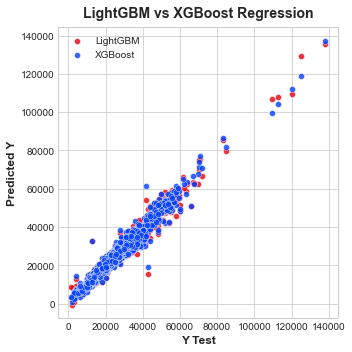

In [85]:
plt.figure(figsize = (5,5))
sns.scatterplot(x=y_test, y=y_pred_lgbm, label='LightGBM', alpha=0.8, color='r')
sns.scatterplot(x=y_test, y=y_pred_xgb, label='XGBoost',alpha=0.8, color='b')
plt.xlabel('Y Test')
plt.ylabel('Predicted Y')
plt.legend(loc='upper left')
plt.title('LightGBM vs XGBoost Regression')

In [86]:
print("RMSE using LightGBM: {} $".format(np.round(np.sqrt(MSE(y_pred_lgbm,y_test)),2)))
print("RMSE using XGBoost: {} $".format(np.round(np.sqrt(MSE(y_pred_xgb,y_test)),2)))

RMSE using LightGBM: 2214.26 $
RMSE using XGBoost: 2176.82 $


In [87]:
print("R2 using LightGBM: {} % ".format(np.round(r2_score(y_test, y_pred_lgbm)*100,2)))
print("R2 using XGBoost: {} % ".format(np.round(r2_score(y_test, y_pred_xgb)*100,2)))

R2 using LightGBM: 96.25 % 
R2 using XGBoost: 96.37 % 


通过观察RMSE和R2的得分，我们可以看到LightGBM的表现比XGBoost略好。

# 特征重要性

In [88]:
xgb_model.feature_names = encoded_df.drop('price', axis = 1).columns

In [89]:
feat_df= pd.DataFrame({'feature': xgb_model.feature_names,'importance':xgb_model.feature_importances_})

In [90]:
sorted_df=feat_df.sort_values('importance', ascending=False)

Text(0.5, 0, 'Feature Importance (%)')

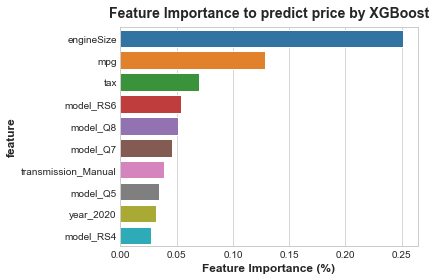

In [91]:
sns.barplot(x='importance', y='feature', data=sorted_df.head(10))
plt.title('Feature Importance to predict price by XGBoost')
plt.xlabel('Feature Importance (%)')

出现了三个车辆的型号，这是独热编码导致的。我们把他们去掉再看看

In [92]:
feat_df2 = feat_df[~feat_df['feature'].astype(str).str.match("model")]


In [93]:
sorted_df2=feat_df2.sort_values('importance', ascending=False)

Text(0, 0.5, '')

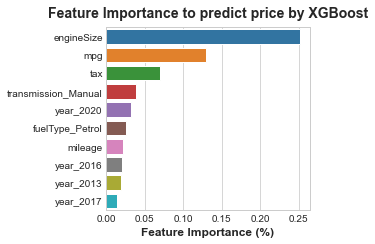

In [94]:
plt.figure(figsize=(4.5,3.5))
sns.barplot(x='importance', y='feature', data=sorted_df2.head(10))
plt.title('Feature Importance to predict price by XGBoost')
plt.xlabel('Feature Importance (%)')
plt.ylabel('')

看来，发动机尺寸和mpg是预测价格的最重要因素。
可以试着用shap画图，能获得更多信息

## 用SHAP看特征重要性

In [95]:
xgb_explainer = shap.TreeExplainer(
    xgb_model, X_train, feature_names = encoded_df.drop('price', axis = 1).columns)

In [96]:
shap_values = xgb_explainer.shap_values(X_train, y_train)

100%|===================| 7902/7903 [01:40<00:00]        

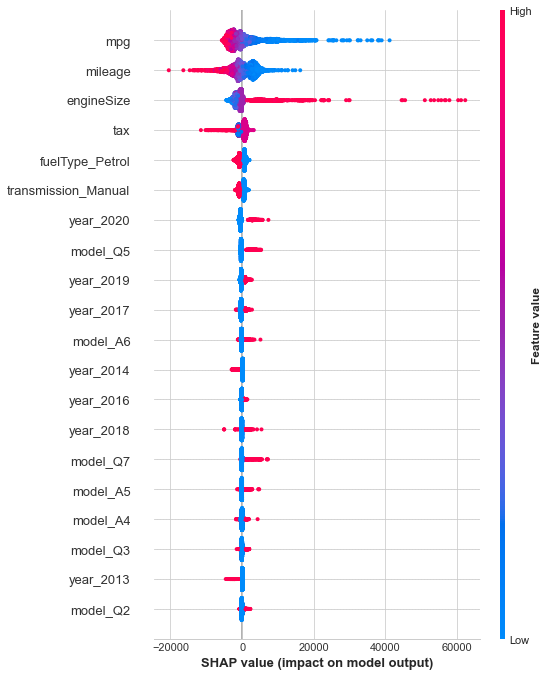

In [97]:
shap.summary_plot(shap_values, X_train, feature_names=encoded_df.drop('price', axis = 1).columns);